## Business Understanding

This project aims to solve the problem of automatically classifying musical chords as either major or minor using audio input. Chord identification is a key task in music analysis, and automating it can save time on transcription and harmonic analysis. By using machine learning and music information retrieval (MIR) techniques, the goal is to create a tool that helps musicians, producers, and educators analyze music in real-time. The project focuses on making chord recognition more accessible and efficient, benefiting both students and professionals in the music industry.

---

## Tools/Methodologies

To handle the workflow, I'll use several Python libraries:

- [librosa](https://librosa.org/doc/latest/index.html) for extracting audio features, [numpy](https://numpy.org/doc/1.24/reference/index.html#reference) and [pandas](https://pandas.pydata.org/docs/reference/index.html#api) for data manipulation, and os and [Kaggle CLI](https://www.kaggle.com/code/donkeys/kaggle-python-api) to download the data directly into the notebook.
- [matplotlib](https://matplotlib.org/stable/api/index.html) and [seaborn](https://seaborn.pydata.org/api.html) for exploring and visualizing features like waveforms and spectrograms.
- [scikit-learn](https://scikit-learn.org/stable/api/index.html) for baseline models (e.g., logistic regression, SVM), and [tensorflow](https://www.tensorflow.org/api_docs/python/tf/all_symbols) or [keras](https://keras.io/api/) for building CNNs.

In [40]:
# Data manipulation
import numpy as np
import pandas as pd
import sklearn
import json
import os

# Audio feature extraction
import librosa
from scipy.signal import find_peaks

# for Kaggle CLI
from kaggle.api.kaggle_api_extended import KaggleApi

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models and utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Deep learning for CNNs
import tensorflow as tf
from tensorflow import keras

## Data Understanding
The dataset used in this project is sourced from the [Musical Instrument Chord Classification (Audio)](https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification) dataset on Kaggle. It contains audio files `.wav` format of chords played on two instruments: guitar and piano. The raw data has been scraped from various sources and is already available for download on Kaggle, eliminating the need for manual data collection. The dataset is well-suited for this project, as it provides a clear distinction between major and minor chords, which is the focus of the classification task.

The features for the model will be extracted from the audio files using techniques such as Mel-frequency cepstral coefficients (MFCCs) or spectrograms, which capture important frequency and temporal information from the audio signals. Although other individuals may have used this dataset for similar chord classification tasks, this project will build upon existing work by focusing specifically on distinguishing between major and minor chords, potentially improving upon current models or exploring new machine learning techniques for this type of classification.

In [2]:
# uncomment if replicating project
# !pip install kaggle

In [3]:
# Load kaggle.json credentials
api_config_path = os.path.join(os.getcwd(), 'kaggle.json')
with open(api_config_path, 'r') as f:
    kaggle_config = json.load(f)

# Set environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Ensure the 'dataset' folder exists
dataset_dir = os.path.join(os.getcwd(), 'dataset')
os.makedirs(dataset_dir, exist_ok=True)

# Use the Kaggle API to download the dataset
api.dataset_download_files('deepcontractor/musical-instrument-chord-classification',
                           path=dataset_dir, unzip=True)

print("Dataset downloaded and extracted to:", dataset_dir)

Dataset URL: https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification
Dataset downloaded and extracted to: C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset


In [4]:
# Define the base directory where the audio files are stored
base_dir = os.path.join(os.getcwd(), 'dataset', 'Audio_Files')

# Prepare to collect file details
file_details = []

# Loop through each category directory ('Major' and 'Minor')
for category in ['Major', 'Minor']:
    category_dir = os.path.join(base_dir, category)
    
    for filename in os.listdir(category_dir):
        if filename.endswith('.wav'):
            # Full path to file
            file_path = os.path.join(category_dir, filename)
            # Append the file path, filename (used as ID), and label to the list
            file_details.append({'path': file_path, 'id': filename, 'label': category})

# Save collected file details as a DataFrame
file_data = pd.DataFrame(file_details)

file_data.head()

,path,id,label
0,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_0.wav,Major
1,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_1.wav,Major
2,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_10.wav,Major
3,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_100.wav,Major
4,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_101.wav,Major


### Model Iterations:

#### Model v1:

First, I wanted to to compare the extract_features method I used in my [last project]() (mostly out of curiosity :p)

This included extracting features like:
- **Chroma Features**: calculated using the short-time Fourier transform (STFT) of the audio file. Chroma features capture the essence of the pitch content within each octave group - which is vital for chord identification.
- **MFCCs**: used to capture the timbral aspects of an audio signal. (This is what makes a song or chord 'feel' a certain way!) The first few coefficients especially provide a good representation of the overall spectral shape which is influenced by the harmonic structure of the chord.

These features were fed into a Convolutional Neural Network (CNN):

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| Major | 0.53      | 1.00   | 0.70     | 46      |
| Minor | 0.00      | 0.00   | 0.00     | 40      |
| **accuracy** | | | 0.53 | 86 |
| **macro avg** | 0.27 | 0.50 | 0.35 | 86 |
| **weighted avg** | 0.29 | 0.53 | 0.37 | 86 |

This is alarming - our scores for precision, recall, and f1-score for the Minor class are ALL zero. 
This is probably because we are focusing in on timbral aspects of the audio, rather than the individual frequencies of the notes in the chords. But an interesting first model!


#### Model v2:

After implementing a new feature extraction method to extract harmonics, these are the results of a simple Logistic Regression as a baseline classifier.

Accuracy: 60.47%

Classification Report (Harmonics & Simple Logistic Regression):

|               | precision | recall | f1-score | support |
|---------------|------------|--------|----------|---------|
| **Major**     | 0.63       | 0.81   | 0.71     | 101     |
| **Minor**     | 0.54       | 0.31   | 0.39     | 71      |
| **accuracy**  |            |        | 0.60     | 172     |
| **macro avg** | 0.58       | 0.56   | 0.55     | 172     |
| **weighted avg** | 0.59    | 0.60   | 0.58     | 172     |

Confusion Matrix:

[[82 19]

 [49 22]]
 
 #### Model v3:
 
 

## Music and Math

Each musical note corresponds to a fundamental frequency - the lowest frequency of a note that is musically pleasing. This frequency is what characterizes the note, which is represented by letters ['A', 'B', 'C', 'D', 'E', 'F', 'G']. 

#### Frequency:

The frequency \( f \) of a note can be calculated with the following formula:

$$ f = f_0 \times 2^{\frac{n}{12}} $$

Where:
- `f_0` is the frequency of a reference note (usually the note **A4**, which is **440 Hz**).
- `n` is the number of half-steps away from the reference note. Positive values of `n` indicate higher notes, while negative values indicate lower notes.

The standard practice in determining the closest note to a given frequency generally involves finding which standard note frequency it's nearest to.

#### Harmonics

A single note played on an instrument does not produce just one frequency. For example, playing an 'A' at 220 Hz will generate additional frequencies at 440 Hz, 660 Hz, 880 Hz, 1100 Hz, and so on. According to this [Music Note Frequency Chart](https://mixbutton.com/mixing-articles/music-note-to-frequency-chart/) the frequencies 220, 440, and 880 Hz correspond to the musical notes A3, A4, and A5, respectively. These notes are all 'A' notes, each one octave apart. The lowest harmonic, known as the fundamental frequency, determines the perceived pitch of the sound.

> In standard musical pitch, A4, or the fourth octave 'A', is tuned to 440 Hz.

Interestingly, the frequency 1100 Hz falls between the frequencies for B5 (987.77 Hz) and C6 (1046.50 Hz). Calculating the midpoint between these two frequencies gives:

$$
\text{Midpoint} = \frac{987.77 \, \text{Hz} + 1046.50 \, \text{Hz}}{2} = 1017.135 \, \text{Hz}
$$

Since 1100 Hz is closer to 1046.50 Hz than to 987.77 Hz, it would be classified closer to C6 in standard musical pitch, though it is somewhat sharper than a typical B5. This illustrates how harmonics work in physical instruments, where playing a fundamental note also produces these higher frequencies, contributing to the richness of the instrument's sound.

#### Chords

A chord represents a combination of several notes played simultaneously, resulting in a harmonious sound. This harmony is achieved through the specific relationship of the frequencies of the notes within the chord. For instance, a simple major chord is composed of the root note, a major third above the root, and a perfect fifth above the root, creating a full and bright sound typically associated with major chords.

Minor chords, on the other hand, are formed by the root note, a minor third above the root, and a perfect fifth above the root, delivering a more melancholic or somber tone compared to major chords.

In addition to major and minor chords, two other common types are diminished and augmented chords. A diminished chord is made up of the root note, a minor third, and a diminished fifth, giving it a tense and unstable sound. An augmented chord consists of the root note, a major third, and an augmented fifth, which creates a sense of suspense or unresolved tension.

#### FourierTransforms

A Fourier transform is a powerful mathematical tool that transforms a signal from its original domain (often time or space) into a frequency domain. This transformation allows us to dissect complex signals and understand how different frequencies contribute to the overall signal. Essentially, it breaks down a wave-like signal into its individual components, highlighting the frequencies that are present.

Why does this help us? Well, by using a Fourier transform, we can analyze various aspects of signals that are not immediately apparent in the time domain. For example, in music production, it helps us identify the specific frequencies that make up a sound, which is crucial for tasks like mixing, mastering, or even sound design. This analysis provides insights into the pitch, tone, and timbre of sounds, helping audio engineers and musicians make informed decisions to enhance musical pieces.

In essence, the Fourier transform is a bridge between the time domain and the frequency domain, providing a comprehensive look at the frequencies that influence a signal. This capability makes it an indispensable tool in fields ranging from audio processing to telecommunications and beyond.

Using a frequency chart to analyze these chords would reveal a complex spectrum due to the concurrent presence of multiple notes. Each note in a chord contributes its fundamental frequency along with its harmonics, leading to a dense array of spikes on the chart. This complex interplay of frequencies helps to understand why chords have their distinctive sounds and emotional impacts.

### Spectogram

A **spectrogram** is a visual representation of the spectrum of frequencies in a sound or other signal as they vary with time. It's essentially a graph that shows the intensity (or loudness) of various frequencies over a period of time. The horizontal axis of a spectrogram represents time, the vertical axis represents frequency, and the colors or shades on the graph indicate the amplitude or strength of the frequencies at any given time. 

#### Why are they useful?

- **Analysis of Sounds**: Spectrograms are incredibly useful for analyzing the characteristics of different sounds, making them indispensable in fields like music production, linguistics, and sound engineering. They help identify variations in frequency that occur over time, which can be crucial for understanding speech patterns, musical notes, and environmental sounds.
- **Signal Processing**: In signal processing, spectrograms provide a clear visualization of how frequencies change, aiding in the enhancement or isolation of specific sounds within a mixed signal.
- **Troubleshooting**: They are also used to diagnose issues in machinery or systems by detecting unusual frequency patterns, which often indicate malfunctions.

In [16]:
from IPython.display import Audio

# To visualize audio data
from scipy.fft import fft
from scipy.io import wavfile

In [17]:
class AudioAnalyzer:
    def __init__(self, df):
        self.df = df

    def play_audio(self, file_id):
        row = self.df.iloc[file_id]
        filename = row['path']
        return Audio(filename)

    def plot_audio(self, file_id, max_freq=None):
        row = self.df.iloc[file_id]
        filename = row['path']
        
        # Read the audio file
        samplerate, data = wavfile.read(filename)
        times = np.arange(len(data)) / float(samplerate)
        
        # Plot time domain data
        plt.figure(figsize=(16, 6))
        plt.subplot(1, 2, 1)
        plt.title("Time Domain")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.plot(times, data)
        
        # Compute and plot frequency domain data
        fft_data = np.fft.fft(data)
        freqs = np.fft.fftfreq(len(fft_data), 1/samplerate)
        magnitude = np.abs(fft_data)[:len(data)//2]
        freqs = freqs[:len(data)//2]
        
        plt.subplot(1, 2, 2)
        plt.title("Frequency Domain")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Magnitude")
        if max_freq is not None:
            plt.xlim([0, max_freq])
        plt.plot(freqs, magnitude)
        plt.show()
        
    def plot_spectrogram(self, file_id, max_freq=None):
        row = self.df.iloc[file_id]
        filename = row['path']
        signal, sr = librosa.load(filename, sr=None)  # Load with the original sample rate

        # Generate the spectrogram
        D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)

        # Plotting the spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
        if max_freq is not None:
            plt.ylim([0, max_freq])
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram')
        plt.xlabel('Time')
        plt.ylabel('Frequency (Hz)')
        plt.tight_layout()
        plt.show()

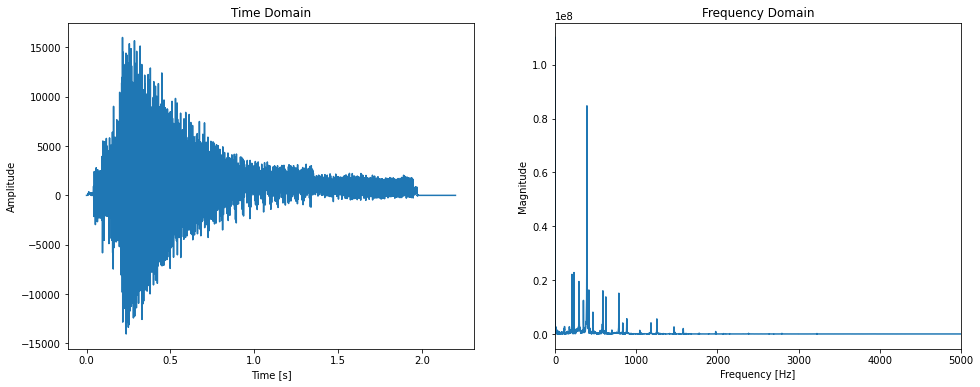

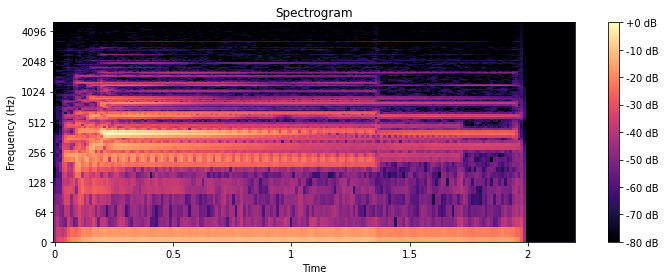

In [18]:
analyzer = AudioAnalyzer(file_data)
file_id = 440 #up to 858

# Play the audio
audio_player = analyzer.play_audio(file_id)
audio_player

# Plot the audio
analyzer.plot_audio(file_id, max_freq=5000)
analyzer.plot_spectrogram(file_id, max_freq=5000)

---

## Data Preparation

The dataset consists of raw .wav files, so no traditional tabular data is available. Preprocessing will involve extracting features like MFCCs, spectrograms, or chroma features to transform the audio into usable data. Challenges include ensuring that these features correctly capture the harmonic information while handling variations in recording quality and instrument type. We estimate several hundred rows of data, each representing an individual chord sample. Visualizations like waveform plots and spectrograms will be used to explore the features that distinguish major from minor chords.

#### Extract Feature Function


#### Encode Labels
Our target feature 'label' should be converted into a numerical format.
> 0: Major 
> 1: Minor

In [28]:
def find_harmonics(file_path, sr=22050, n_fft=2048):
    try:
        # Load the audio file
        y, sr = librosa.load(file_path, sr=sr)

        # Perform Fourier Transform to get the frequency spectrum
        fft_result = np.fft.fft(y)
        magnitude = np.abs(fft_result)  # Magnitude of the Fourier Transform
        frequency = np.fft.fftfreq(len(magnitude), 1/sr)  # Frequency bins

        # Only keep the positive frequencies
        positive_freq_idxs = np.where(frequency >= 0)
        positive_freqs = frequency[positive_freq_idxs]
        positive_magnitude = magnitude[positive_freq_idxs]

        # Find peaks in the frequency spectrum
        peaks, _ = find_peaks(positive_magnitude, height=np.max(positive_magnitude) * 0.1)  # threshold at 10% of the max

        # Get the corresponding frequencies of the peaks
        harmonic_frequencies = positive_freqs[peaks]

        # Return the harmonic frequencies
        return harmonic_frequencies
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [29]:
harmonics_data = []

# Extracting harmonics for each file and storing them in a list
for index, row in file_data.iterrows():
    harmonics = find_harmonics(row['path'])
    if harmonics is not None:
        harmonics_data.append({
            'id': row['id'].replace('.wav', ''),
            'Label': row['label'],
            'harmonics': harmonics  # Store the harmonics as a list for now
        })

# Find the maximum number of harmonics across all files
max_harmonics = max(len(item['harmonics']) for item in harmonics_data)

# Prepare a list to hold each row's dictionary
harmonics_dict_list = []

for item in harmonics_data:
    harmonic_dict = {
        'id': item['id'],
        'Label': item['Label']
    }
    
    # Fill harmonic frequencies, and pad with NaN if there are fewer than max_harmonics
    for i in range(max_harmonics):
        harmonic_dict[f'harmonic_{i+1}'] = item['harmonics'][i] if i < len(item['harmonics']) else np.nan
    
    harmonics_dict_list.append(harmonic_dict)

# Create a new DataFrame from the list of dictionaries
harmonics_df = pd.DataFrame(harmonics_dict_list)

# Display the first few rows of the new DataFrame
print(harmonics_df.head())

          id  Label  harmonic_1  harmonic_2  harmonic_3  harmonic_4  \
0    Major_0  Major  130.665350  165.331667  195.998025  262.219580   
1    Major_1  Major  165.331667  196.442465  261.775140  329.774454   
2   Major_10  Major  130.909091  185.000000  234.090909  262.272727   
3  Major_100  Major  155.454545  195.909091  278.181818  311.363636   
4  Major_101  Major  155.909091  196.818182  197.727273  278.181818   

   harmonic_5  harmonic_6  harmonic_7  harmonic_8  ...  harmonic_24  \
0  329.330014  330.218894  391.996049  392.884929  ...          NaN   
1  331.107774  392.440489  495.995001  523.994719  ...          NaN   
2  329.545455  370.454545  393.181818  468.181818  ...          NaN   
3  349.545455  392.272727  466.818182  556.363636  ...          NaN   
4  311.363636  350.454545  392.727273  466.818182  ...          NaN   

   harmonic_25  harmonic_26  harmonic_27  harmonic_28  harmonic_29  \
0          NaN          NaN          NaN          NaN          NaN   
1     

In [34]:
harmonic_columns = [col for col in harmonics_df.columns if col.startswith('harmonic_')]

---

# Modeling

This is a classification problem, with the goal of predicting whether a chord is major or minor. The initial plan is to use a basic model like logistic regression or SVM as a baseline. After extracting features like MFCCs or spectrograms, we will establish the baseline and then experiment with more advanced models like convolutional neural networks (CNNs) to improve accuracy.

In [31]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [36]:
# Split data into features and target
X = harmonics_df[harmonic_columns]
y = harmonics_df['Label'] 

# Handle missing values (NaNs)
X.loc[:, :] = X.fillna(0)

# Splitting the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<ipython-input-36-5bd790f538ef>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, :] = X.fillna(0)


In [37]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
# Model configuration
input_shape = (X_train.shape[1], 1)

# Building the model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

LogisticRegression(max_iter=1000, random_state=42)

---

# Evaluation

To evaluate the model, we will use metrics such as accuracy, precision, recall, and F1-score, focusing on correctly classifying both major and minor chords. The minimum viable product (MVP) will involve building a baseline model (e.g., logistic regression or SVM) to classify the chords with reasonable accuracy. Stretch goals include improving the model using more complex techniques like CNNs or RNNs, and addressing any data imbalances to achieve better generalization and robustness.

In [39]:
# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print detailed classification report (precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 60.47%

Classification Report:
              precision    recall  f1-score   support

       Major       0.63      0.81      0.71       101
       Minor       0.54      0.31      0.39        71

    accuracy                           0.60       172
   macro avg       0.58      0.56      0.55       172
weighted avg       0.59      0.60      0.58       172

Confusion Matrix:
[[82 19]
 [49 22]]


---

# Deployment

The results will be delivered through a simple Streamlit web app, where users can upload or record audio files to classify as major or minor chords. The app will provide real-time feedback, displaying the classification result along with confidence scores and visualizations such as waveforms or spectrograms. The app will be hosted on Streamlit Cloud, making it easily accessible and user-friendly for quick chord analysis.